In [1]:
import os
os.getenv("LD_LIBRARY_PATH")

':/home/annazan/miniconda3/envs/fair38/lib/'

In [2]:
!echo $LD_LIBRARY_PATH
!source ~/.bashrc
!echo $LD_LIBRARY_PATH


/bin/bash: /home/annazan/miniconda3/envs/fair38/lib/libtinfo.so.6: no version information available (required by /bin/bash)
:/home/annazan/miniconda3/envs/fair38/lib/
/bin/bash: /home/annazan/miniconda3/envs/fair38/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/annazan/miniconda3/envs/fair38/lib/libtinfo.so.6: no version information available (required by /bin/bash)
:/home/annazan/miniconda3/envs/fair38/lib/


In [3]:

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import os
import sys
print(os.getcwd())
os.environ.update(os.environ)
        # Add a new environment variable to the operating system
os.environ["RAMP_HOME"] = os.getcwd()
# Print the environment variables to verify that the new variable was added
print(os.environ["RAMP_HOME"])
sys.path.append('../')
sys.path.append('../ramp-code/')
sys.path.append('ramp-code')


/home/annazan/fAIr-utilities
/home/annazan/fAIr-utilities


In [5]:
import warnings
warnings.filterwarnings("ignore")
os.environ["SM_FRAMEWORK"] = "tf.keras"
import cv2
import ramp.utils
import hot_fair_utilities

# base_path = f"{os.getcwd()}/ramp-data/sample_2"
# base_path = "/home/annazan/fAIr-utilities/ramp-data/test_data/1_Zanzibar"
# base_path = f"{os.getcwd()}/ramp-data/test_data/1_Zanzibar"
base_path = f'{os.getcwd()}/ramp-data/test_data/model95_td370/'
model_input_image_path = f"{base_path}/input"
preprocess_output=f"{base_path}/preprocessed"
train_output = f"{base_path}/train"

Segmentation Models: using `tf.keras` framework.


In [6]:
# from hot_fair_utilities import preprocess

# preprocess(
#     input_path = model_input_image_path,
#     output_path = preprocess_output,
#     rasterize=True,
#     # rasterize_options=["binary"],
#     rasterize_options=["binary"],
#     georeference_images=True,

# )

In [7]:
# # Make multimask path
# !mkdir ramp-data/test_data/1_Zanzibar/preprocessed/multimasks/
# # Run script for multi-mask: https://github.com/kshitijrajsharma/ramp-code-fAIr/blob/ae33b11364f0a61f278ce9ff93446586704ea275/scripts/multi_masks_from_polygons.py
# !python ramp-code/scripts/multi_masks_from_polygons.py -in_vecs ramp-data/test_data/1_Zanzibar/preprocessed/labels/ -in_chips ramp-data/test_data/1_Zanzibar/preprocessed/chips/ -out ramp-data/test_data/1_Zanzibar/preprocessed/multimasks/ -bwidth 2 -csp 4

In [8]:
preprocess_output=f"{base_path}"

from hot_fair_utilities.training.prepare_data import split_training_2_validation
x = split_training_2_validation(preprocess_output, train_output)

ramp home is /home/annazan/fAIr-utilities
python home is None
variables are: src /home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/
 and dst:/home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370//train


Writing /home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370//train/fair_split_train.csv
Writing /home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370//train/fair_split_val.csv


In [9]:
import datetime
from ramp.training import (
    callback_constructors,
    loss_constructors,
    metric_constructors,
    model_constructors,
    optimizer_constructors,
)

In [10]:
from hot_fair_utilities.training.run_training import manage_fine_tuning_config

output_path=train_output
epoch_size=2
batch_size=2
freeze_layers=False
cfg = manage_fine_tuning_config(
            output_path, epoch_size, batch_size, freeze_layers
        )

In [11]:
print("Config:")
print(cfg)

Config:
{'experiment_name': 'HOT-OSM Efficient-Unet Finetune model_set1_batch20_epoch20_imgAug', 'discard_experiment': False, 'logging': {'log_experiment': True, 'experiment_log_path': 'ramp-data/TRAIN/fAIr-experiments.csv', 'experiment_notes': 'Binary Mask model, batchsize 20, 20 epochs on HOT-OSM dataset 1 Multizoom, finetuning from RAMP saved model', 'fields_to_log': ['experiment_name', 'experiment_notes', 'timestamp', 'num_epochs', 'batch_size', 'output_img_shape', 'input_img_shape', 'get_loss_fn_name', 'use_saved_model', 'use_aug', 'use_early_stopping', 'use_clr', 'random_seed', 'num_classes', 'get_optimizer_fn_name', 'tb_logs_dir', 'get_model_fn_name', 'backbone', 'train_img_dir', 'train_mask_dir', 'val_img_dir', 'val_mask_dir']}, 'datasets': {'train_img_dir': '/home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370//train/chips', 'train_mask_dir': '/home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370//train/binarymasks', 'val_img_dir': '/home/annazan/fAIr-utilit

In [12]:
discard_experiment = False
if "discard_experiment" in cfg:
    discard_experiment = cfg["discard_experiment"]
cfg["timestamp"] = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [13]:
# specify a function that will construct the loss function
get_loss_fn_name = cfg["loss"]["get_loss_fn_name"]

#---
# TODO: manually changing here for OHE experiment
get_loss_fn_name = "get_categorical_crossentropy_fn"
#---

get_loss_fn = getattr(loss_constructors, get_loss_fn_name)
# Construct the loss function
loss_fn = get_loss_fn(cfg)

the_metrics = []
if cfg["metrics"]["use_metrics"]:
    get_metrics_fn_names = cfg["metrics"]["get_metrics_fn_names"]
    get_metrics_fn_parms = cfg["metrics"]["metrics_fn_parms"]
    assert len(get_metrics_fn_names) == len(get_metrics_fn_parms)
    
    
    #---
    # TODO: manually changing here for OHE experiment
    get_metrics_fn_names = ["get_precision_fn", "get_iou_fn"]
    get_metrics_fn_parms = [{}, {}]
    #---
    for get_mf_name, mf_parms in zip(get_metrics_fn_names, get_metrics_fn_parms):
        
        get_metric_fn = getattr(metric_constructors, get_mf_name)
        print(f"Metric constructor function: {get_metric_fn.__name__}")
        metric_fn = get_metric_fn(mf_parms)
        the_metrics.append(metric_fn)

Metric constructor function: get_precision_fn
Metric constructor function: get_iou_fn


In [14]:
from pathlib import Path

#### construct optimizer ####
get_optimizer_fn_name = cfg["optimizer"]["get_optimizer_fn_name"]
get_optimizer_fn = getattr(optimizer_constructors, get_optimizer_fn_name)

optimizer = get_optimizer_fn(cfg)

the_model = None

# SG: Using the saved model in this cell
working_ramp_home = os.environ["RAMP_HOME"]
# load (construct) the model
model_path = Path(working_ramp_home) / cfg["saved_model"]["saved_model_path"]
print(f"Model: importing saved model {str(model_path)}")
the_model = tf.keras.models.load_model(model_path)
assert (
    the_model is not None
), f"the saved model was not constructed: {model_path}"

if cfg["freeze_layers"]:
    for layer in the_model.layers:
        layer.trainable = False  # freeze previous layers only update new layers
        # print("Setting previous model layers traininable : False")


print("-------")
print(f'-------{the_metrics}')
print("-------")

# If you don't want to save the original state of training, recompile the model.
the_model.compile(optimizer=optimizer, loss=loss_fn, metrics=[the_metrics])
# the_model.compile(optimizer=optimizer, loss=loss_fn, metrics=[precision_class_0,precision_class_1])

# the_model.compile(optimizer = optimizer,
#    loss=loss_fn,
#    metrics = [get_iou_coef_fn])

Model: importing saved model /home/annazan/fAIr-utilities/ramp-code/ramp/checkpoint.tf
-------
-------[<keras.metrics.metrics.Precision object at 0x7f468851ed60>, <keras.metrics.metrics.IoU object at 0x7f46885313d0>]
-------


In [15]:
# Example of non-sparse loss fn with probs over labels and OHE labels (total 4 classes)
y_true = tf.one_hot([0, 1], depth=4, axis=-1)
y_pred = [[0.05, 0.95, 0, 0], [0.1, 0.8, 0.1, 0]]
loss_fn(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.609438>

In [16]:
the_model.loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.609438>

In [17]:
# print("Model summary:")
# print(the_model.summary())

In [18]:
#---
# TODO: manually changing here for OHE experiment
def ohe_batches(batches: tf.data.Dataset, depth=4) -> tf.data.Dataset:
    """For given batches and depth map sparse labels to OHE."""
    return batches.map(lambda x, y: (x, tf.one_hot(y[..., -1], depth, axis=-1)))
#---

In [19]:
from ramp.training.augmentation_constructors import get_augmentation_fn
from ramp.utils.misc_ramp_utils import get_num_files
from ramp.data_mgmt.data_generator import (
    test_batches_from_gtiff_dirs,
    training_batches_from_gtiff_dirs,
)
#### define data directories ####
train_img_dir = Path(working_ramp_home) / cfg["datasets"]["train_img_dir"]
train_mask_dir = Path(working_ramp_home) / cfg["datasets"]["train_mask_dir"]
val_img_dir = Path(working_ramp_home) / cfg["datasets"]["val_img_dir"]
val_mask_dir = Path(working_ramp_home) / cfg["datasets"]["val_mask_dir"]

#### get the augmentation transform ####
# aug = None
if cfg["augmentation"]["use_aug"]:
    aug = get_augmentation_fn(cfg)

## RUNTIME Parameters
batch_size = cfg["batch_size"]
input_img_shape = cfg["input_img_shape"]
output_img_shape = cfg["output_img_shape"]

n_training = get_num_files(train_img_dir, "*.tif")
n_val = get_num_files(val_img_dir, "*.tif")
steps_per_epoch = n_training // batch_size
validation_steps = n_val // batch_size
# Testing step , not recommended
if validation_steps <= 0:
    validation_steps = 1

# add these back to the config
# in case they are needed by callbacks
cfg["runtime"] = {}
cfg["runtime"]["n_training"] = n_training
cfg["runtime"]["n_val"] = n_val
cfg["runtime"]["steps_per_epoch"] = steps_per_epoch
cfg["runtime"]["validation_steps"] = validation_steps

train_batches = None

if aug is not None:
    train_batches = training_batches_from_gtiff_dirs(
        train_img_dir,
        train_mask_dir,
        batch_size,
        input_img_shape,
        output_img_shape,
        transforms=aug,
    )
else:
    train_batches = training_batches_from_gtiff_dirs(
        train_img_dir, train_mask_dir, batch_size, input_img_shape, output_img_shape
    )
assert train_batches is not None, "training batches were not constructed"
print(f"-------\n* train img dir{train_img_dir}\n* train mask dir{train_mask_dir}")
print(f"* input img shape{input_img_shape}\n* output img shape{output_img_shape}")


#---
# TODO: manually changing here for OHE experiment
train_batches = ohe_batches(train_batches)
#---
print(train_batches)

-------
* train img dir/home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/train/chips
* train mask dir/home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/train/binarymasks
* input img shape[256, 256]
* output img shape[256, 256]
<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None))>


In [20]:
# Batches are a tf.data.Dataset type
print(train_batches)

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None))>


In [21]:

# Get a single batch as numpy to explore
iter = tf.data.Dataset.as_numpy_iterator(train_batches)
(X_batch, y_true_batch) = iter.next()


In [22]:
y_true_batch[0, 0, 0, :]

array([1., 0., 0., 0.], dtype=float32)

In [23]:
import numpy as np
# Print useful info
print("Batch size is:", X_batch.shape[0])
# Appears to be floats between 0 and 1
print("Example X entry:", X_batch[0, 0, 0, :])
print("Input data shape (X):", X_batch.shape)
print("Ground truth data shape (y_true):", y_true_batch.shape)
print("Example y_true: ", y_true_batch[1, 0, 0, :])
print(f"The unique labels in the y_true: {np.unique(y_true_batch[0, :, :, 0])}")

Batch size is: 2
Example X entry: [0.06786785 0.06786785 0.06786785]
Input data shape (X): (2, 256, 256, 3)
Ground truth data shape (y_true): (2, 256, 256, 4)
Example y_true:  [0. 1. 0. 0.]
The unique labels in the y_true: [0. 1.]


In [24]:
# Get some predictions from the model for the batch
y_pred_batch = the_model.predict(X_batch)

1/1 [==============================] - 3s 3s/step


In [25]:
# Shape of output predictions
print("Predictions y_pred_batch are:", y_pred_batch.shape)


Predictions y_pred_batch are: (2, 256, 256, 4)


In [26]:
# Example single pixel prediction
single_prediction = y_pred_batch[0, 0, 0, :]
print(single_prediction)

# Single prediction sums to 1: probabilties over the four categories of the model
single_prediction.sum().round()

[9.9108499e-01 4.7262857e-04 8.2368916e-03 2.0547237e-04]


1.0

In [27]:
the_model.loss(y_true_batch, y_pred_batch)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6845751>

In [28]:
# Validation batches
val_batches = test_batches_from_gtiff_dirs(
    val_img_dir, val_mask_dir, batch_size, input_img_shape, output_img_shape
)

#---
# TODO: manually changing here for OHE experiment
val_batches = ohe_batches(val_batches)
#---

assert val_batches is not None, "validation batches were not constructed"
print(f"-------\n* val img dir{val_img_dir}\n* val mask dir{val_mask_dir}\n-------")
print(val_batches)
print('*\n*\n')


-------
* val img dir/home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/train/val-chips
* val mask dir/home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/train/val-binarymasks
-------
<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None))>
*
*



In [29]:
# Set up training
# ---------------
## Callbacks ##
callbacks_list = []

if not discard_experiment:
    # get model checkpoint callback
    if cfg["model_checkpts"]["use_model_checkpts"]:
        get_model_checkpt_callback_fn_name = cfg["model_checkpts"][
            "get_model_checkpt_callback_fn_name"
        ]
        get_model_checkpt_callback_fn = getattr(
            callback_constructors, get_model_checkpt_callback_fn_name
        )
        callbacks_list.append(get_model_checkpt_callback_fn(cfg))

    # get tensorboard callback
    if cfg["tensorboard"]["use_tb"]:
        get_tb_callback_fn_name = cfg["tensorboard"]["get_tb_callback_fn_name"]
        get_tb_callback_fn = getattr(callback_constructors, get_tb_callback_fn_name)
        callbacks_list.append(get_tb_callback_fn(cfg))

    # get tensorboard model prediction logging callback
    if cfg["prediction_logging"]["use_prediction_logging"]:
        assert cfg["tensorboard"][
            "use_tb"
        ], "Tensorboard logging must be turned on to enable prediction logging"
        get_prediction_logging_fn_name = cfg["prediction_logging"][
            "get_prediction_logging_fn_name"
        ]
        get_prediction_logging_fn = getattr(
            callback_constructors, get_prediction_logging_fn_name
        )
        callbacks_list.append(get_prediction_logging_fn(the_model, cfg))

# free up RAM
tf.keras.backend.clear_session()

if cfg["early_stopping"]["use_early_stopping"]:
    callbacks_list.append(callback_constructors.get_early_stopping_callback_fn(cfg))

    # get cyclic learning scheduler callback
if cfg["cyclic_learning_scheduler"]["use_clr"]:
    assert not cfg["early_stopping"][
        "use_early_stopping"
    ], "cannot use early_stopping with cycling_learning_scheduler"
    get_clr_callback_fn_name = cfg["cyclic_learning_scheduler"][
        "get_clr_callback_fn_name"
    ]
    get_clr_callback_fn = getattr(callback_constructors, get_clr_callback_fn_name)
    callbacks_list.append(get_clr_callback_fn(cfg))

In [30]:
call = callbacks_list[0]
call.filepath

'/home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/train/model-checkpts/20240306-140533/model_20240306-140533_{epoch:03d}_{val_precision_1:.3f}.tf'

In [31]:

import matplotlib.pyplot as plt
from time import perf_counter

## Main training block ##
n_epochs = cfg["num_epochs"]
# SG: manually make this 10
n_epochs = 10
print(
    f"Starting Training with {n_epochs} epochs , {batch_size} batch size , {steps_per_epoch} steps per epoch , {validation_steps} validation steps......"
)
if validation_steps <= 0:
    raise RaiseError(
        "Not enough data for training, Increase image or Try reducing batchsize/epochs"
    )
# FIXME : Make checkpoint
start = perf_counter()
history = the_model.fit(
    train_batches,
    epochs=n_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_batches,
    validation_steps=validation_steps,
    callbacks=callbacks_list,
)
end = perf_counter()
print(f"Training Finished , Time taken to train : {end-start} seconds")
print('\n-----\nHistory:')
print(history.history.keys())
print('\n-----')


Starting Training with 10 epochs , 2 batch size , 71 steps per epoch , 12 validation steps......
Epoch 1/10
71/71 [==============================] - 38s 421ms/step - loss: 0.8504 - precision_1: 0.6577 - iou: 0.4382 - val_loss: 0.3638 - val_precision_1: 0.9293 - val_iou: 0.4888
Epoch 2/10
71/71 [==============================] - 9s 100ms/step - loss: 0.3959 - precision_1: 0.7676 - iou: 0.4444 - val_loss: 0.3034 - val_precision_1: 0.9128 - val_iou: 0.4872
Epoch 3/10
71/71 [==============================] - 27s 389ms/step - loss: 0.3433 - precision_1: 0.7639 - iou: 0.4408 - val_loss: 0.2111 - val_precision_1: 0.9338 - val_iou: 0.3926
Epoch 4/10
71/71 [==============================] - 7s 102ms/step - loss: 0.3106 - precision_1: 0.7620 - iou: 0.4360 - val_loss: 0.1667 - val_precision_1: 0.8477 - val_iou: 0.4378
Epoch 5/10
71/71 [==============================] - 7s 102ms/step - loss: 0.2639 - precision_1: 0.8072 - iou: 0.4367 - val_loss: 0.1876 - val_precision_1: 0.8620 - val_iou: 0.4595
E

Generating graphs ....
Graph generated at : /home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370//train/graphs
accuracy [0.6577438116073608, 0.7676373720169067, 0.7638641595840454, 0.7620459198951721, 0.8071892857551575, 0.7969008684158325, 0.785211980342865, 0.7737615704536438, 0.8491490483283997, 0.7972997426986694]
accuracy [0.9293320775032043, 0.9128451347351074, 0.9338300228118896, 0.8476808667182922, 0.8619670271873474, 0.7954358458518982, 0.8803215026855469, 0.8602098226547241, 0.8509362936019897, 0.9141762852668762]
loss [0.8504456281661987, 0.3959389925003052, 0.3432747721672058, 0.31064924597740173, 0.2639405131340027, 0.2573508024215698, 0.2696053683757782, 0.260934442281723, 0.19671539962291718, 0.24077078700065613]


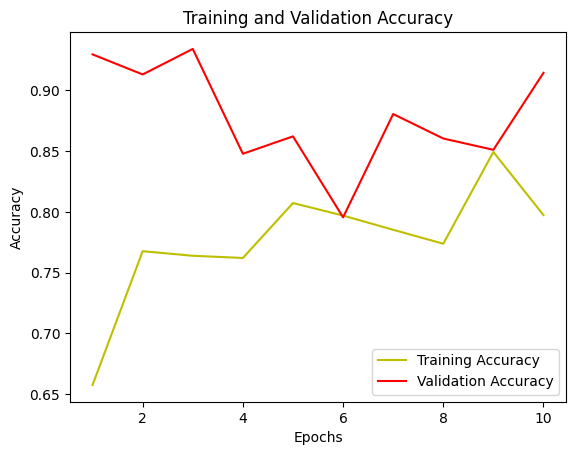

In [37]:

# plot the training and validation accuracy and loss at each epoch
print("Generating graphs ....")
if not os.path.exists(cfg["graph_location"]):
    os.mkdir(cfg["graph_location"])

loss = history.history["loss"]
# val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

# acc = history.history["sparse_categorical_accuracy"]
# val_acc = history.history["val_sparse_categorical_accuracy"]

#---
# TODO: updated for OHE
acc = history.history["precision_1"]
val_acc = history.history["val_precision_1"]
#---

# Plot training and validation accuracy
plt.plot(epochs, acc, "y", label="Training Accuracy")
plt.plot(epochs, val_acc, "r", label="Validation Accuracy")

# Set labels and title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

plt.legend()
plt.savefig(
    f"{cfg['graph_location']}/training_validation_sparse_categorical_accuracy.png"
)
print(f"Graph generated at : {cfg['graph_location']}")
print(f"accuracy {acc}")
print(f"accuracy {val_acc}")
print(f"loss {loss}")


In [39]:
print(history.history.keys())
print(history.history["val_iou"])

dict_keys(['loss', 'precision_1', 'iou', 'val_loss', 'val_precision_1', 'val_iou'])
[0.4887550175189972, 0.487190842628479, 0.3925529420375824, 0.43777579069137573, 0.4594821333885193, 0.449368953704834, 0.3898741602897644, 0.3908065855503082, 0.38196274638175964, 0.40484076738357544]


In [34]:

# # APPENDIX: from copying across

# #### construct optimizer ####
# get_optimizer_fn_name = cfg["optimizer"]["get_optimizer_fn_name"]
# get_optimizer_fn = getattr(optimizer_constructors, get_optimizer_fn_name)

# optimizer = get_optimizer_fn(cfg)

# the_model = None

# if cfg["saved_model"]["use_saved_model"]:
#     # load (construct) the model
#     model_path = Path(working_ramp_home) / cfg["saved_model"]["saved_model_path"]
#     print(f"Model: importing saved model {str(model_path)}")
#     the_model = tf.keras.models.load_model(model_path)
#     assert (
#         the_model is not None
#     ), f"the saved model was not constructed: {model_path}"

#     if cfg["freeze_layers"]:
#         for layer in the_model.layers:
#             layer.trainable = False  # freeze previous layers only update new layers
#             # print("Setting previous model layers traininable : False")

#     if not cfg["saved_model"]["save_optimizer_state"]:
#         print("-------")
#         print(f'-------{the_metrics}')
#         print("-------")
        
#         # For class 0
#         precision_class_0 = Precision(class_id=0)
#         # For class 1
#         precision_class_1 = Precision(class_id=1)
#         metrics=[precision_class_0,precision_class_1]
#         print(f'-------{the_metrics}')
#         print("-------")
        
#         # If you don't want to save the original state of training, recompile the model.
#         the_model.compile(optimizer=optimizer, loss=loss_fn, metrics=[the_metrics])
#         # the_model.compile(optimizer=optimizer, loss=loss_fn, metrics=[precision_class_0,precision_class_1])
        
#         # the_model.compile(optimizer = optimizer,
#         #    loss=loss_fn,
#         #    metrics = [get_iou_coef_fn])

# if not cfg["saved_model"]["use_saved_model"]:
#     get_model_fn_name = cfg["model"]["get_model_fn_name"]
#     get_model_fn = getattr(model_constructors, get_model_fn_name)
#     the_model = get_model_fn(cfg)

#     assert the_model is not None, f"the model was not constructed: {model_path}"
#     the_model.compile(optimizer=optimizer, loss=loss_fn, metrics=the_metrics)

# print(the_model)
# cfg["datasets"]

# #### define data directories ####
# train_img_dir = Path(working_ramp_home) / cfg["datasets"]["train_img_dir"]
# train_mask_dir = Path(working_ramp_home) / cfg["datasets"]["train_mask_dir"]
# val_img_dir = Path(working_ramp_home) / cfg["datasets"]["val_img_dir"]
# val_mask_dir = Path(working_ramp_home) / cfg["datasets"]["val_mask_dir"]

# #### get the augmentation transform ####
# # aug = None
# if cfg["augmentation"]["use_aug"]:
#     aug = get_augmentation_fn(cfg)

# ## RUNTIME Parameters
# batch_size = cfg["batch_size"]
# input_img_shape = cfg["input_img_shape"]
# output_img_shape = cfg["output_img_shape"]

# n_training = get_num_files(train_img_dir, "*.tif")
# n_val = get_num_files(val_img_dir, "*.tif")
# steps_per_epoch = n_training // batch_size
# validation_steps = n_val // batch_size
# # Testing step , not recommended
# if validation_steps <= 0:
#     validation_steps = 1

# # add these back to the config
# # in case they are needed by callbacks
# cfg["runtime"] = {}
# cfg["runtime"]["n_training"] = n_training
# cfg["runtime"]["n_val"] = n_val
# cfg["runtime"]["steps_per_epoch"] = steps_per_epoch
# cfg["runtime"]["validation_steps"] = validation_steps

# train_batches = None

# if aug is not None:
#     train_batches = training_batches_from_gtiff_dirs(
#         train_img_dir,
#         train_mask_dir,
#         batch_size,
#         input_img_shape,
#         output_img_shape,
#         transforms=aug,
#     )
# else:
#     train_batches = training_batches_from_gtiff_dirs(
#         train_img_dir, train_mask_dir, batch_size, input_img_shape, output_img_shape
#     )

# assert train_batches is not None, "training batches were not constructed"
# print(f"-------\n* train img dir{train_img_dir}\n* train mask dir{train_mask_dir}")
# print(f"* input img shape{input_img_shape}\n* output img shape{output_img_shape}")

# print(train_batches)

# val_batches = test_batches_from_gtiff_dirs(
#     val_img_dir, val_mask_dir, batch_size, input_img_shape, output_img_shape
# )

# assert val_batches is not None, "validation batches were not constructed"
# print(f"-------\n* val img dir{val_img_dir}\n* val mask dir{val_mask_dir}\n-------")
# print(val_batches)
# print('*\n*\n')

# ## Callbacks ##
# callbacks_list = []

# if not discard_experiment:
#     # get model checkpoint callback
#     if cfg["model_checkpts"]["use_model_checkpts"]:
#         get_model_checkpt_callback_fn_name = cfg["model_checkpts"][
#             "get_model_checkpt_callback_fn_name"
#         ]
#         get_model_checkpt_callback_fn = getattr(
#             callback_constructors, get_model_checkpt_callback_fn_name
#         )
#         callbacks_list.append(get_model_checkpt_callback_fn(cfg))

#     # get tensorboard callback
#     if cfg["tensorboard"]["use_tb"]:
#         get_tb_callback_fn_name = cfg["tensorboard"]["get_tb_callback_fn_name"]
#         get_tb_callback_fn = getattr(callback_constructors, get_tb_callback_fn_name)
#         callbacks_list.append(get_tb_callback_fn(cfg))

#     # get tensorboard model prediction logging callback
#     if cfg["prediction_logging"]["use_prediction_logging"]:
#         assert cfg["tensorboard"][
#             "use_tb"
#         ], "Tensorboard logging must be turned on to enable prediction logging"
#         get_prediction_logging_fn_name = cfg["prediction_logging"][
#             "get_prediction_logging_fn_name"
#         ]
#         get_prediction_logging_fn = getattr(
#             callback_constructors, get_prediction_logging_fn_name
#         )
#         callbacks_list.append(get_prediction_logging_fn(the_model, cfg))

# # free up RAM
# keras.backend.clear_session()

# if cfg["early_stopping"]["use_early_stopping"]:
#     callbacks_list.append(callback_constructors.get_early_stopping_callback_fn(cfg))

#     # get cyclic learning scheduler callback
# if cfg["cyclic_learning_scheduler"]["use_clr"]:
#     assert not cfg["early_stopping"][
#         "use_early_stopping"
#     ], "cannot use early_stopping with cycling_learning_scheduler"
#     get_clr_callback_fn_name = cfg["cyclic_learning_scheduler"][
#         "get_clr_callback_fn_name"
#     ]
#     get_clr_callback_fn = getattr(callback_constructors, get_clr_callback_fn_name)
#     callbacks_list.append(get_clr_callback_fn(cfg))

# ## Main training block ##
# n_epochs = cfg["num_epochs"]
# print(
#     f"Starting Training with {n_epochs} epochs , {batch_size} batch size , {steps_per_epoch} steps per epoch , {validation_steps} validation steps......"
# )
# if validation_steps <= 0:
#     raise RaiseError(
#         "Not enough data for training, Increase image or Try reducing batchsize/epochs"
#     )
# # FIXME : Make checkpoint
# start = perf_counter()
# history = the_model.fit(
#     train_batches,
#     epochs=n_epochs,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=val_batches,
#     validation_steps=validation_steps,
#     callbacks=callbacks_list,
# )
# end = perf_counter()
# print(f"Training Finished , Time taken to train : {end-start} seconds")
# print('\n-----\nHistory:')
# print(history.history.keys())
# print('\n-----')

# # plot the training and validation accuracy and loss at each epoch
# print("Generating graphs ....")
# if not os.path.exists(cfg["graph_location"]):
#     os.mkdir(cfg["graph_location"])

# loss = history.history["loss"]
# # val_loss = history.history["val_loss"]
# epochs = range(1, len(loss) + 1)

# acc = history.history["sparse_categorical_accuracy"]
# val_acc = history.history["val_sparse_categorical_accuracy"]

# # Plot training and validation accuracy
# plt.plot(epochs, acc, "y", label="Training Accuracy")
# plt.plot(epochs, val_acc, "r", label="Validation Accuracy")

# # Set labels and title
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.title("Training and Validation Accuracy")

# plt.legend()
# plt.savefig(
#     f"{cfg['graph_location']}/training_validation_sparse_categorical_accuracy.png"
# )
# print(f"Graph generated at : {cfg['graph_location']}")
# print(f"accuracy {acc}")
# print(f"accuracy {val_acc}")
# print(f"loss {loss}")


In [35]:
import pandas as pd
df = pd.read_csv("/home/annazan/fAIr-utilities/ramp-data/test_data/1_Zanzibar/train/fair_split_train.csv")
df.iloc[0, 0]

'/home/annazan/fAIr-utilities/ramp-data/test_data/1_Zanzibar/train/chips/OAM-319292-270962-19.tif'

In [36]:
from hot_fair_utilities import train
train_output = f"{base_path}train"
final_accuracy, final_model_path = train(
    input_path=preprocess_output,
    output_path=train_output,
    epoch_size=2,
    batch_size=2,
    model="ramp",
    model_home=os.environ["RAMP_HOME"]
)

variables are /home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/
 and /home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/train
Starting to prepare data for training
ramp home is /home/annazan/fAIr-utilities
python home is None
variables are: src /home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/
 and dst:/home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/train


Writing /home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/train/fair_split_train.csv
Writing /home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/train/fair_split_val.csv


done split
Data is ready for training
Metric constructor function: get_precision_fn
Model: importing saved model /home/annazan/fAIr-utilities/ramp-code/ramp/checkpoint.tf
-------
-------[<keras.metrics.metrics.Precision object at 0x7f46893cf0d0>]
-------
-------[<keras.metrics.metrics.Precision object at 0x7f46893cf0d0>]
-------
-------
* train img dir/home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/train/chips
* train mask dir/home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/train/binarymasks
* input img shape[256, 256]
* output img shape[256, 256]
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>
-------
* val img dir/home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/train/val-chips
* val mask dir/home/annazan/fAIr-utilities/ramp-data/test_data/model95_td370/train/val-binarymasks
-------
<BatchDataset element_spec=(TensorSpec(shape

ValueError: in user code:

    File "/home/annazan/miniconda3/envs/fair38/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/annazan/miniconda3/envs/fair38/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/annazan/miniconda3/envs/fair38/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/annazan/miniconda3/envs/fair38/lib/python3.8/site-packages/keras/engine/training.py", line 894, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/annazan/miniconda3/envs/fair38/lib/python3.8/site-packages/keras/engine/training.py", line 987, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/annazan/miniconda3/envs/fair38/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 501, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/annazan/miniconda3/envs/fair38/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/annazan/miniconda3/envs/fair38/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/annazan/miniconda3/envs/fair38/lib/python3.8/site-packages/keras/metrics/metrics.py", line 818, in update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    File "/home/annazan/miniconda3/envs/fair38/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 619, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (None, 256, 256, 4) and (None, 256, 256, 1) are incompatible


[here a tf file is created (weights + structure)]

In [ ]:
print(final_accuracy,final_model_path)

In [ ]:
prediction_output = f"{os.getcwd()}/outputs/model51_td364/prediction"

In [ ]:


from hot_fair_utilities import predict


print(f"\n**\n** prediction output {prediction_output}")
print(f"\n**\n** prediction input {base_path}prediction/input")
predict(
    checkpoint_path=final_model_path,
    input_path=f"{base_path}prediction/input",
    prediction_path=prediction_output,
)

In [ ]:
from hot_fair_utilities import polygonize
geojson_output= f"{prediction_output}/prediction.geojson"
polygonize(
    input_path=prediction_output, 
    output_path=geojson_output,
    remove_inputs = True,
)